# 链接仪器

In [1]:
%matplotlib notebook
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from qulab.wavepoint import WAVE_FORM as WF
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new, measureroutine_new
from qulab.optimize import Collect_Waveform 
from qulab.math import opt
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
mn = imp.reload(measureroutine_new)
opt = imp.reload(opt)

In [2]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
# #awg135 = await connect('AWG135')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
#ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
psg104 = await connect('PSG104')
psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
# # #pna = await connect('PNA')

In [3]:
psg_lo = psg104
psg_ex1 = psg105
psg_ex2 = psg106
psg_ex3 = psg103
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_ex2':psg_ex2,'psg_ex3':psg_ex3,'psg_pump':psg_pump}
ats = ats18
awg_trig = awg100
dc = {'dc01':dc01,'dc02':dc02,'dc03':dc03,'dc05':dc05,'dc06':dc06,\
      'dc07':dc07,'dc08':dc08,'dc10':dc10,'dc11':dc11,'dc15':dc15,'dc20':dc20}
#awg = awg132
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133}

In [4]:
measure = mr.common(1,ats,dc,psg,awg_list,1)

In [5]:
async def resn(f_cavity):
    f_lo = f_cavity.max() + 50e6
    delta =  f_lo - f_cavity 
    n = len(f_cavity)
    return f_lo, delta, n

In [6]:
f_cavity = np.array([6.505,6.518,6.531,6.544,6.559,6.573,6.587,6.600,6.605,6.630])*1e9
f_lo, delta, n = await resn(f_cavity)
delta

array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
       9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])

In [5]:
delta = np.array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
       9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])
delta = np.array([50e6])
await mr.modulation_read(measure,delta,tdelay=1500)
# await mr.ats_setup(ats,delta,l=1500)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [7]:
state = await mr.QueryInst(measure)
pd.DataFrame(state)

,dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_lo,psg_ex1,psg_ex2,psg_ex3,psg_pump
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,0,0,0,0,+0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.200000GHz,4.054883GHz,3.769000GHz,6.611080GHz,12.602000GHz
load,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,NaN,NaN,NaN,NaN,NaN
mform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXT,EXT,EXT,EXT,INT
moutput,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
offset,0,0,0.005,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1
power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000dBm,0.000000dBm,13.000000dBm,18.000000dBm,-2.270000dBm


In [89]:
await psg_pump.setValue('Output','OFF')

In [23]:
for i in np.arange(100):
    await psg_ex3.query('syst:err?')

# 测背底

In [8]:
async def S21(freq):
    await psg_lo.setValue('Output','ON')
    for i in freq:
        await psg_lo.setValue('Frequency', i)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
#         theta0 = np.angle(Am) - np.angle(Bm)
#         Bm *= np.exp(1j*theta0)
        s = Am + 1j*Bm
        yield [i-50e6], s

In [9]:
freq = np.linspace(-300,400,701)*1e6 + 6.3e9 + 50e6
# freq = [f_lo]
tag = 'jpa'
mr.Att_Setup(measure,"COM7").Att(13)
await dc03.DC(0)
await psg_pump.setValue('Output','OFF')
job = Job(S21, (freq,), tags=[tag], max=len(freq))
f, base = await job.done()

COM7 open...
last ATT 13.0
now ATT 13.0


Output()

In [29]:
f, base = f.reshape(len(f),1), base.reshape(len(f),1)

<IPython.core.display.Javascript object>


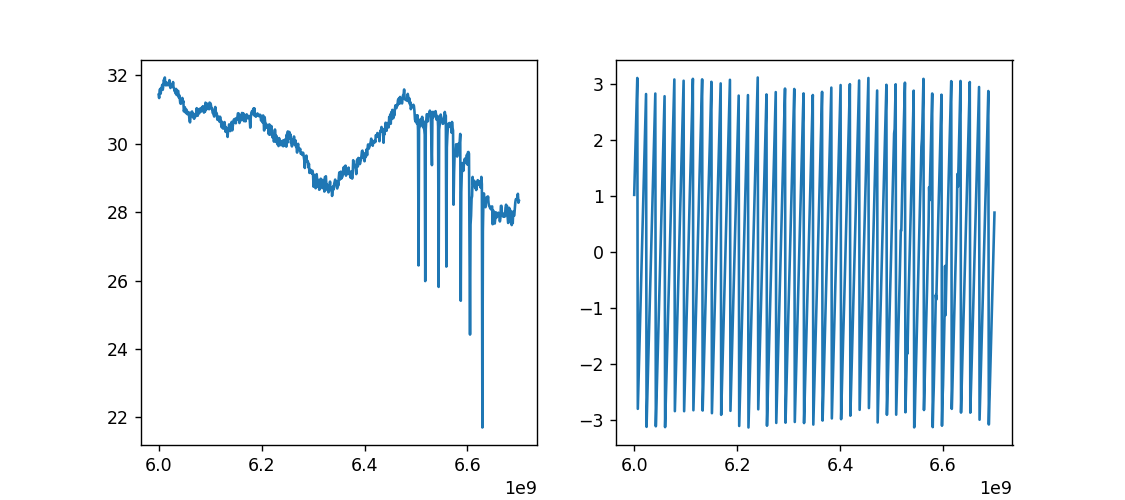

In [10]:

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f[:,0],20*np.log10(np.abs(base[:,0])))
axes[1].plot(f[:,0],np.angle(base[:,0]))
plt.show()

<IPython.core.display.Javascript object>


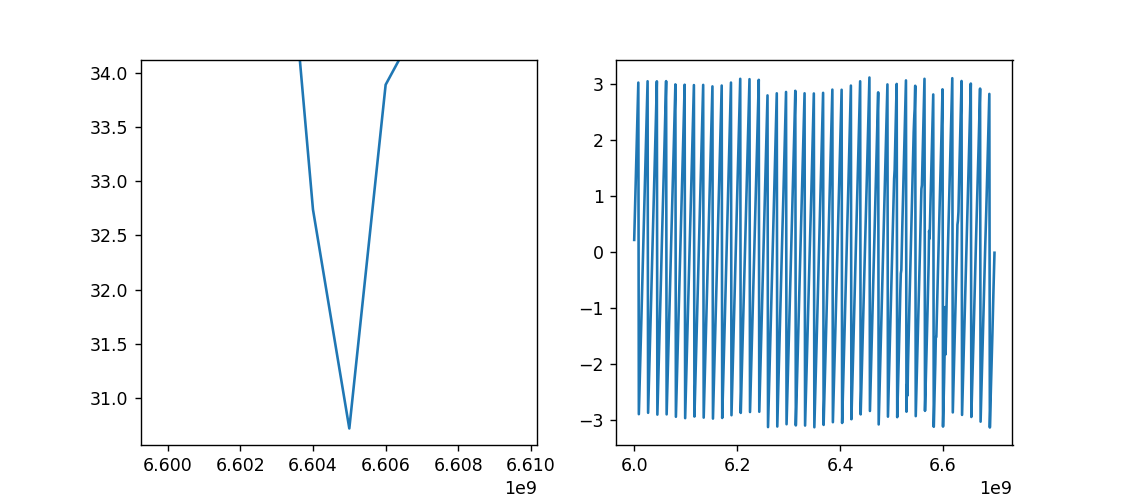

In [12]:

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f[:,0],20*np.log10(np.abs(base[:,0])))
axes[1].plot(f[:,0],np.angle(base[:,0]))
plt.show()

In [55]:
# f_cavity = np.array([6.505,6.518,6.531,6.544,6.559,6.573,6.587,6.600,6.605,6.630])*1e9 + 50e6

array([6.10e+09, 6.25e+09, 6.35e+09, 6.45e+09, 6.65e+09])

# S21vsFlux

In [33]:
async def S21vsFlux(freq,current):
    await psg_ex.setValue('Output','OFF')
    await psg_pump.setValue('Output','OFF')
    await psg_lo.setValue('Output','ON')
    for i in current:
        await dc03.DC(i)
        job = Job(S21, (freq,),auto_save=False, no_bar=True, tags=['test'], max=len(freq))
        f_s21, s_s21 = await job.done()
        yield [i]*1, f_s21, s_s21

In [34]:
#freq = np.linspace(-500,500,1001)*1e6 + 6.3e9
current = np.linspace(-1,1,21)
job = Job(S21vsFlux, (freq,current), tags=[tag], max=len(current))
volt, f_bias, s_bias = await job.done()

Output()

In [35]:
await dc03.DC(0)

## 扣除相位

<IPython.core.display.Javascript object>


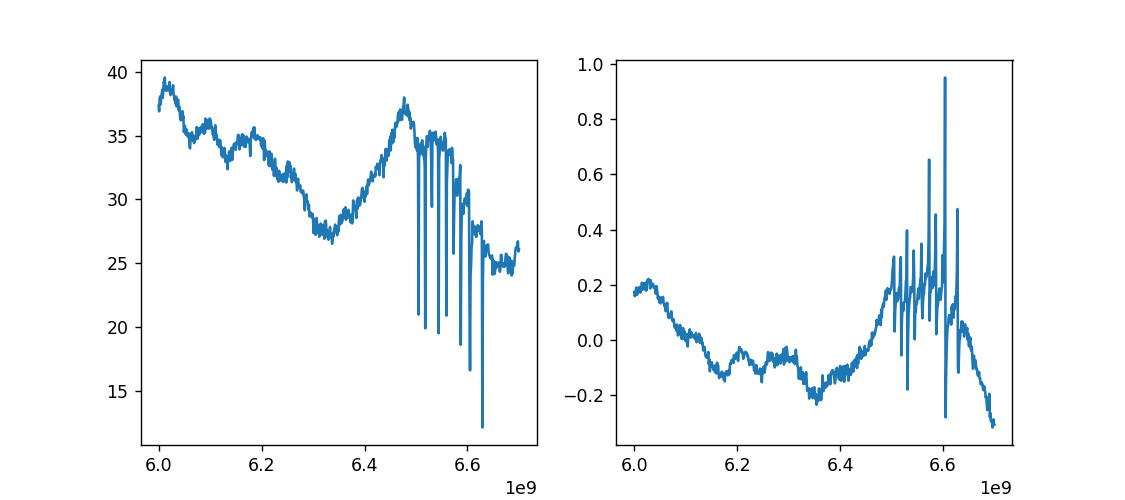

In [12]:
phi = np.unwrap(np.angle(base[:,0]), 0.9 * np.pi)
phase = np.poly1d(np.polyfit(f[:,0], phi, 1))
s21_base = base[:,0] / np.exp(1j * phase(f[:,0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f[:,0],np.abs(s21_base))
axes[1].plot(f[:,0],np.angle(s21_base))
plt.show()

In [17]:
s21 = []
for i in s_bias[:,:,0]:
    phi = np.unwrap(np.angle(i), 0.9 * np.pi)
    phase = np.poly1d(np.polyfit(f[:,0], phi, 1))
    sm = i / np.exp(1j * phase(f[:,0]))
    s21.append(sm)
s21 = np.array(s21)

## 扣除背底

<IPython.core.display.Javascript object>


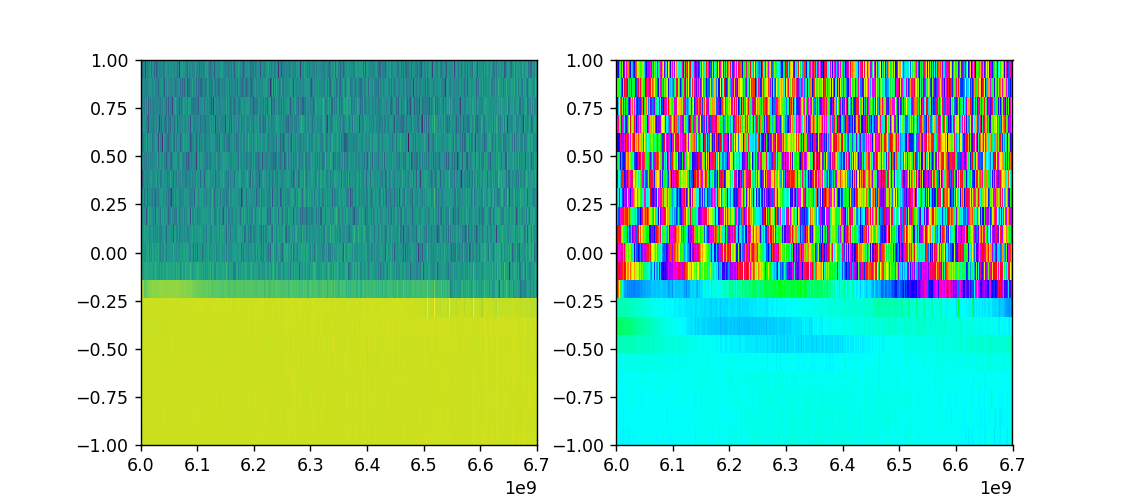

In [18]:
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_bias),np.max(f_bias),np.min(volt),np.max(volt)]
axes[0].imshow(20*np.log10(np.abs(s21/s21_base)),extent=extent,aspect='auto',origin='lower')
axes[1].imshow(np.angle(s21/s21_base),extent=extent,aspect='auto',origin='lower',cmap='hsv')
plt.show()

# BiasvsPump

In [95]:
await psg_pump.setValue('Output','OFF')
await mr.modulation_read(measure,np.array([50e6]),tdelay=1500)
await psg_lo.setValue('Frequency',(6.3e9+50e6))
await dc03.DC(0)
ch_A, ch_B = await ats.getIQ()
Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
theta0 = np.angle(Am) - np.angle(Bm)
Bm *= np.exp(1j*theta0)
base_single = Am + Bm
base_single = base_single / np.exp(1j * phase(6.3e9))
print(await ats.getValue('f_list'))

[50000000.]


In [96]:
async def SingleBias(bias):
    await psg_lo.setValue('Output','ON')
    await psg_lo.setValue('Frequency',(6.3e9+50e6))
    for i in bias:
        await dc03.DC(i)
        ch_A, ch_B = await ats.getIQ()
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield [i], s / np.exp(1j * phase(6.3e9))

In [97]:
async def BiasvsPump(bias,pump):
#     await psg_ex.setValue('Output','OFF')
    await psg_pump.setValue('Output','ON')
    await psg_pump.setValue('Frequency',(2*(6.3e9)+2e6))
    for i in pump:
        await psg_pump.setValue('Power',i)
        job = Job(SingleBias, (bias,),auto_save=False, no_bar=True, tags=['test'], max=len(bias))
        v_sb, s_sb = await job.done()
        yield [i]*1, v_sb, s_sb

In [98]:
power = np.linspace(-7,0,29)
current = np.linspace(-2,2,101)
job = Job(BiasvsPump, (current,power), tags=[tag], max=len(power))
p_pump, v_pump, s_pump = await job.done()

Output()

<IPython.core.display.Javascript object>


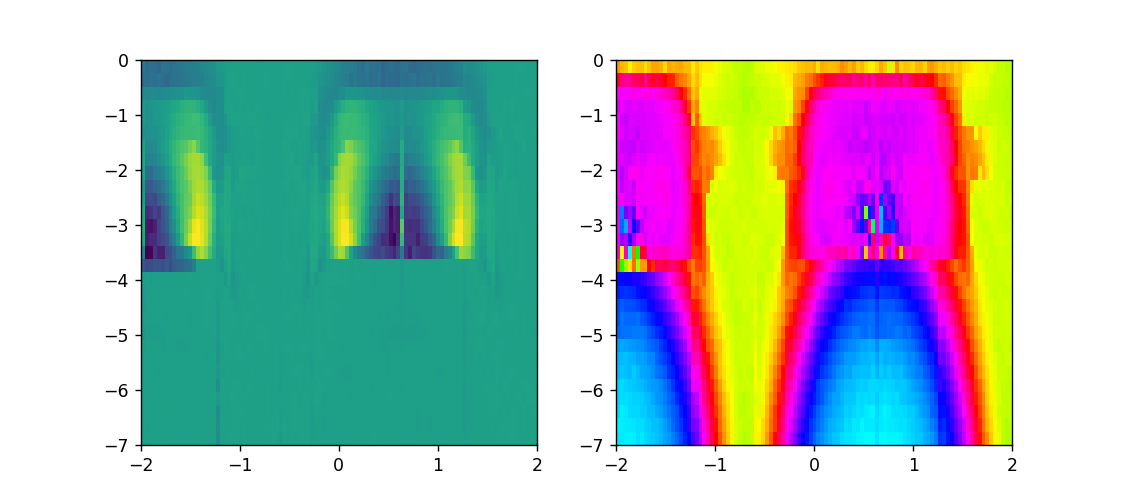

In [99]:
s = (s_pump[:,:,0] / base_single) #检查shape
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(v_pump),np.max(v_pump),np.min(p_pump),np.max(p_pump)]
axes[0].imshow(20*np.log10(np.abs(s)),extent=extent,aspect='auto',origin='lower')
axes[1].imshow(np.angle(s),extent=extent,aspect='auto',origin='lower',cmap='hsv')
plt.show()

In [100]:
index = np.argmax(np.abs(s))
c_op, p_op = current[index%len(current)],power[index//len(current)]
print('current=%f, power=%f'%(c_op,p_op))

current=-1.440000, power=-3.250000


## 单条检测

Output()

<IPython.core.display.Javascript object>


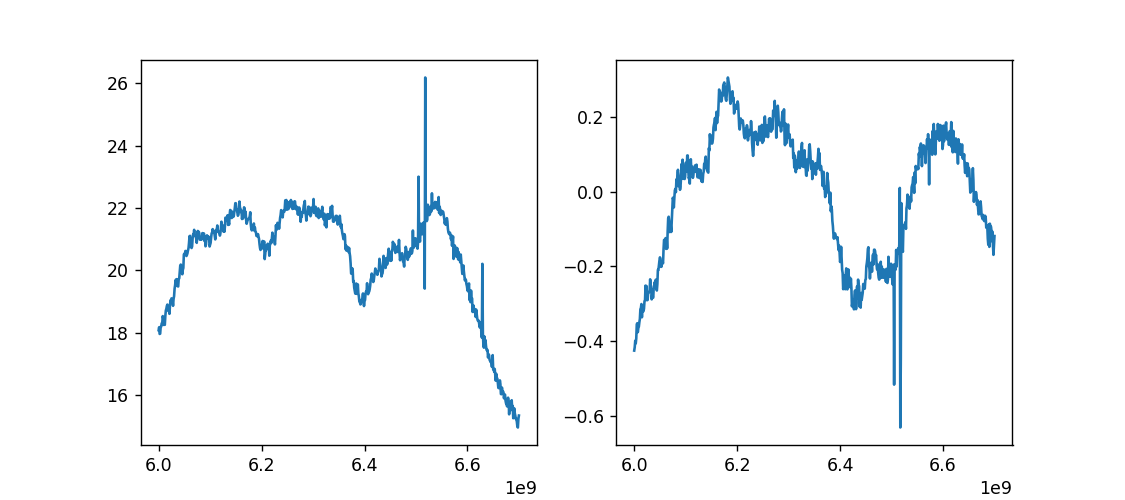

In [19]:
await dc03.DC(-0.023)
await psg_pump.setValue('Power',-2.55)
await psg_pump.setValue('Output','ON')
await mr.modulation_read(measure,np.array([50e6]),tdelay=1500)
job = Job(S21, (freq,), tags=[tag], max=len(freq))
f_test, s_test = await job.done()
f_tests, s_tests = op.RowToRipe().deductPhase(f_test[:,0],s_test[:,0])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_tests,20*np.log10(np.abs(s_tests[0]/s21_base)))
axes[1].plot(f_tests,np.angle(s_tests[0]/s21_base))
plt.show()

In [57]:
f_cavity

array([6.20e+09, 6.25e+09, 6.35e+09, 6.45e+09, 6.65e+09])

## 单纯形法

In [16]:
f_cavity = np.array([freq[150],freq[200],freq[300],freq[400],freq[600]])
tag = 'jpa'
await dc03.DC(0)
await psg_pump.setValue('Output','OFF')
job = Job(S21, (f_cavity,), tags=[tag], max=len(f_cavity))
f_sn, base_sn = await job.done()
base_sn = base_sn[:,0] / np.exp(1j * phase(f_sn[:,0]))

Output()

In [57]:
# async def Gain(bias,power):
#     global f_cavity
#     await dc03.DC(bias)
#     await psg101.setValue('Power',power)
#     job = Job(S21, (f_cavity,), tags=[tag], max=len(f_cavity),no_bar=True)
#     f_tests, s_tests = await job.done()
#     s_tests = s_tests[:,0] / np.exp(1j * phase(f_tests[:,0]))
#     index = np.abs(s_tests/base_sn).argmin()
#     return -20*np.log10(np.abs(s_tests[index]/base_sn[index]))

In [17]:
async def SNR(bias,power):
    global f_cavity
    await dc03.DC(bias)
    await psg101.setValue('Power',power)
    s_tests = []
    for i in f_cavity:
        await psg104.setValue('Frequency',i)
        ch_A, ch_B = await ats18.getIQ()
        s = ch_A + 1j*ch_B
        s_tests.append(s / np.exp(1j * phase(i)))
    snr = np.abs(np.mean(np.array(s_tests) ,axis=1)) / np.std(np.array(s_tests),axis=1) 
    return -np.min(snr[:,0])
#     return bias**2 + power**2

In [18]:
await psg_pump.setValue('Output','ON')
await mr.ats_setup(ats18,np.array([50e6]),l=1500,repeats=5000)
opt.optimize(SNR,[0.046,-3.25],[0.01,0.1],[3,2],print_info=True,algorithm='minimize')

.o
[ 0.046 -3.25 ] -4.992261086007637   ..o
[ 0.046 -3.15 ] -6.263746645225809   .o
[ 0.036 -3.15 ] -6.56731859346022   .o
[ 0.026 -3.1  ] -7.012708572140503   .o
[ 0.026 -3.   ] -7.301823739167383   ..o
[ 0.006 -2.95 ] -7.427250463061106   .o
[-0.014 -2.85 ] -7.6152816341448   .o
[-0.014 -2.75 ] -7.639588229849238   .o
[-0.034 -2.58 ] -7.705277292625649   ......o
[-0.013 -2.72 ] -7.73365555769624   ..o
[-0.019 -2.58 ] -7.800277502641463   ......o
[-0.03 -2.51] -7.820796727527676   ...o
[-0.023 -2.53 ] -7.859303110288693   ..o
[-0.023 -2.55 ] -7.876444839752932   ....................................
 CacheInfo(hits=28, misses=38, maxsize=128, currsize=38)


 final_simplex: (array([[-0.02271094, -2.55053711],
       [-0.02271292, -2.5504549 ],
       [-0.02271843, -2.55046685]]), array([-7.87644484, -7.87644484, -7.87644484]))
           fun: -7.876444839752932
       message: 'Optimization terminated successfully.'
          nfev: 66
           nit: 24
        status: 0
       success: True
             x: array([-0.023, -2.55 ])

## 多条检测

In [18]:
async def SingleS21(current,freq):
    for i in current:
        await dc03.DC(i)
        job = Job(S21, (freq,), tags=[tag],no_bar = True, max=len(freq))
        f_test, s_test = await job.done()
        yield [i], f_test, s_test

In [21]:
current = np.linspace(-0.04,0.08,61)
await psg_pump.setValue('Power',-5)
await psg_pump.setValue('Output','ON')
await psg_lo.setValue('Output','ON')
job = Job(SingleS21, (current,freq), tags=[tag], max=len(current))
v_test, f_test, s_test = await job.done()

Output()

In [22]:
await dc03.DC(0)
await psg_pump.setValue('Output','OFF')

<IPython.core.display.Javascript object>


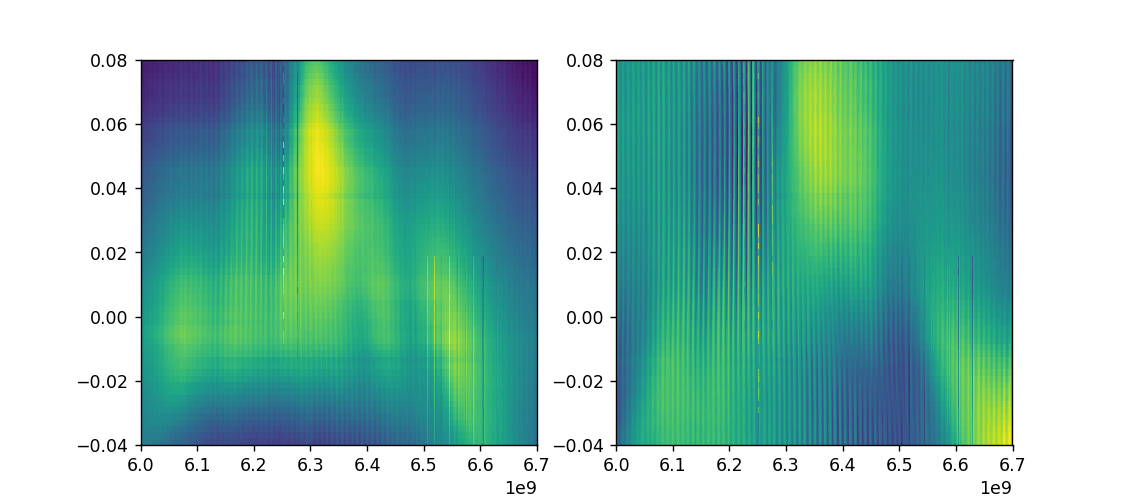

In [24]:
f_testn, s_testn = op.RowToRipe().deductPhase(f_test[:,:,0][0],s_test[:,:,0])

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_testn),np.max(f_testn),np.min(v_test),np.max(v_test)]
axes[0].imshow(20*np.log10(np.abs(s_testn/s21_base)),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_testn/s21_base),extent=extent,origin='lower',aspect='auto')
plt.show()

In [414]:
fig, axes = plt.subplots(ncols=2,nrows=(len(current)//2+len(current)%2),figsize=(9,2*(len(current)//2+len(current)%2)))
for j, i in enumerate(s_test):
    axes[j//2][j%2].plot(f_test,20*np.log10(np.abs(i/s21_base)))
    axes[j//2][j%2].settitle('%d'%j)
    #axes[j//2][1].plot(f_test,np.angle(i/s21_base))
plt.show()

# S21vsPump

In [400]:
async def S21vsPump(freq,pump):
    await psg_ex.setValue('Output','OFF')
    await psg_pump.setValue('Output','ON')
    await psg_lo.setValue('Output','ON')
    for i in pump:
        await psg_pump.setValue('Power',i)
        job = Job(S21, (freq,),auto_save=False, no_bar=True, tags=['test'], max=len(freq))
        f_s21, s_s21 = await job.done()
        yield [i]*1, f_s21, s_s21

In [401]:
power = np.linspace(-0.5,0.5,21) + p_op
await dc03.DC(-0.012)
job = Job(S21vsPump, (freq,power), tags=[tag], max=len(power))
p_p, f_p, s_p = await job.done()

Output()

In [404]:
f_pn, s21_pump = op.RowToRipe().deductPhase(f_p[:,:,0][0],s_p[:,:,0])

<IPython.core.display.Javascript object>


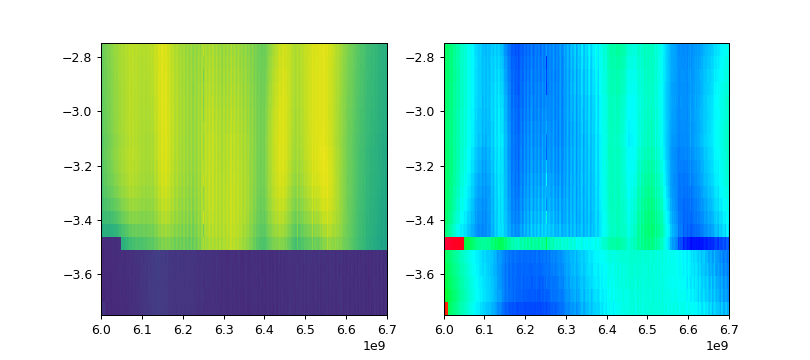

In [405]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_pn),np.max(f_pn),np.min(p_p),np.max(p_p)]
axes[0].imshow(20*np.log10(np.abs(s21_pump/s21_base)),extent=extent,aspect='auto',origin='lower')
axes[1].imshow(np.angle(s21_pump/s21_base),extent=extent,aspect='auto',origin='lower',cmap='hsv')
plt.show()

In [415]:
# fig, axes = plt.subplots(ncols=2,nrows=(len(power)//2+len(power)%2),figsize=(9,2*(len(power)//2+len(power)%2)))
# for j, i in enumerate(s21_pump):
#     axes[j//2][j%2].plot(f_pn,20*np.log10(np.abs(i/s21_base)))
#     axes[j//2][j%2].set_title('%d'%j)
#     #axes[j//2][1].plot(f_test,np.angle(i/s21_base))
# plt.show()

In [416]:
power[11]

-3.2

# 噪声

In [ ]:
Tp = (Y - 1) / Gp / Gi**2 / Ga * Th  #Th=4K, Ga线的衰减， Gi环形器的插入损耗， Gp：JPA增益

In [14]:
async def NoiseFreq(freq):
    
    for j, i in enumerate(freq):
        await psg_lo.setValue('Frequency',i)
        #JPA打开
        await psg_pump.setValue('Output','ON')
        time.sleep(0.1)
        ch_A, ch_B = await ats.getIQ()
        son = ch_A + 1j*ch_B
        sigma_on = np.std(son/np.exp(1j * phase(i-50e6)))
        Gp = 20*np.log10(np.abs(s.mean(axis=0)/base[:,0][j]))
        #JPA关上
        await psg_pump.setValue('Output','OFF')
        time.sleep(0.1)
        ch_A, ch_B = await ats.getIQ()
        soff = ch_A + 1j*ch_B
        sigma_off = np.std(soff/np.exp(1j * phase(i-50e6)))
        
        Y = sigma_on**2 / sigma_off**2
#         Tp = (Y - 1) / Gp / Gi**2 / Ga * Th
        yield [i-50e6],[Y,Gp]

In [137]:
await dc03.DC(0.015)
await psg_pump.setValue('Power',-2.35)
await mr.modulation_read(measure,np.array([50e6]),tdelay=1500)
await mr.ats_setup(ats18,np.array([50e6]),l=1500,repeats=1000)
job = Job(NoiseFreq, (freq,), tags=[tag], max=len(freq))
f_nf, T_nf = await job.done()

Output()

<IPython.core.display.Javascript object>


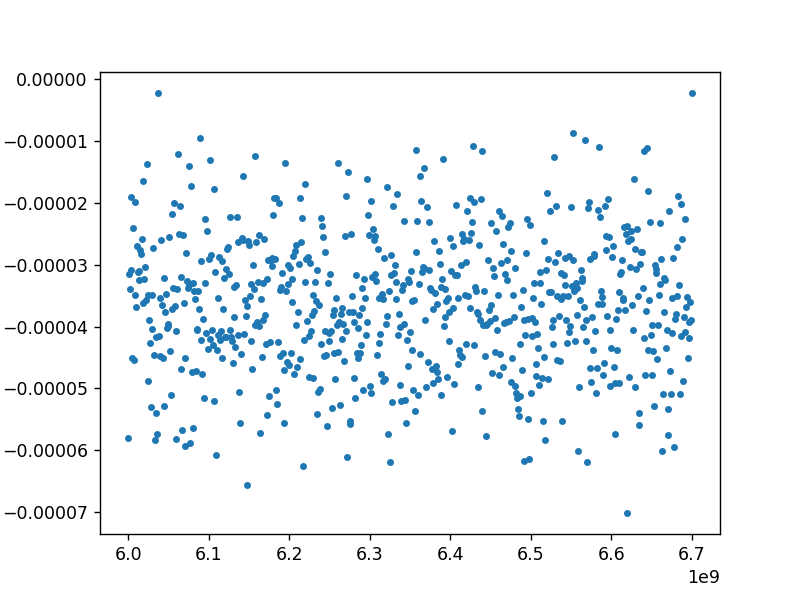

In [134]:
fig  = plt.figure()
Gi, Ga, Th = -4, -5, 4
plt.plot(f_nf,T_nf,'.')
plt.show()

# 饱和功率

In [49]:
async def SaturationPower(signalpower,att_setup):
    for i in signalpower:
        att_setup.Att(i,closeinst=False)
        sm = []
        for j in [[0,'OFF'],[0.02,'ON']]:
            await dc03.DC(j[0])
            await psg_pump.setValue('Output',j[1])
            ch_A, ch_B = await ats.getIQ()
            Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
            theta0 = np.angle(Am) - np.angle(Bm)
            Bm *= np.exp(1j*theta0)
            s = Am + Bm
            sm.append(s)
        yield [i]*10, sm

In [50]:
att_setup = mr.Att_Setup(measure,"COM7")
signalpower = np.linspace(0,20,41)
await psg_pump.setValue('Power',-2.35)
await psg_lo.setValue('Frequency',f_lo)
job = Job(SaturationPower, (signalpower,att_setup), tags=['jpa'], max=len(signalpower))
a_sp, s_sp = await job.done()
att_setup.close()

COM7 open...
last ATT 20.0


Output()

In [51]:
await dc03.DC(0)
await psg_pump.setValue('Output','OFF')

In [52]:
readpower, singalgain = a_sp,20*np.log10(np.abs(s_sp[:,1,:]/s_sp[:,0,:]))

<IPython.core.display.Javascript object>


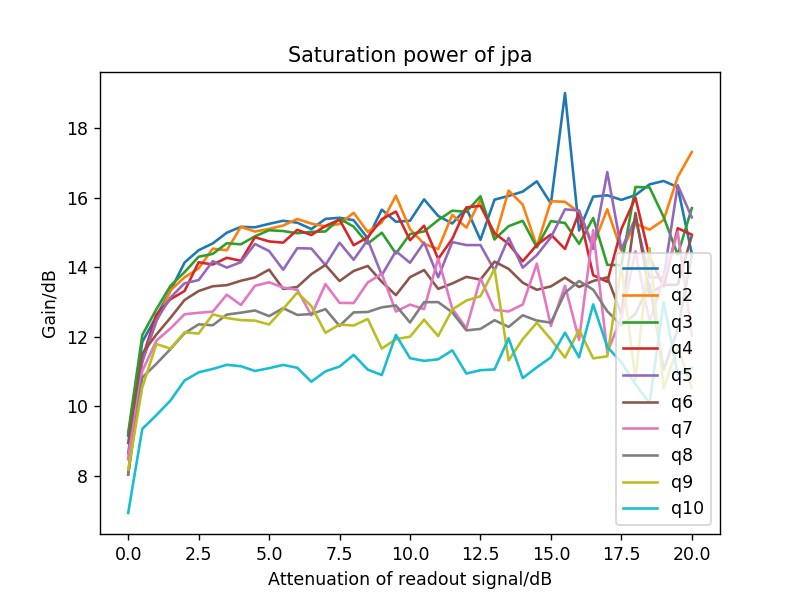

In [53]:
fig = plt.figure()
plt.plot(a_sp,20*np.log10(np.abs(s_sp[:,1,:]/s_sp[:,0,:])))
plt.legend(loc=4,labels=['q%d'%(i+1) for i in range(10)])
plt.title('Saturation power of jpa')
plt.ylabel('Gain/dB')
plt.xlabel('Attenuation of readout signal/dB')
plt.show()

In [48]:
await ats.getValue('f_list')

array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
       9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])

In [54]:
f_lo

6680000000.0

In [72]:
from scipy.optimize import basinhopping

In [73]:
help(basinhopping)

Help on function basinhopping in module scipy.optimize._basinhopping:

basinhopping(func, x0, niter=100, T=1.0, stepsize=0.5, minimizer_kwargs=None, take_step=None, accept_test=None, callback=None, interval=50, disp=False, niter_success=None, seed=None)
    Find the global minimum of a function using the basin-hopping algorithm
    
    Basin-hopping is a two-phase method that combines a global stepping
    algorithm with local minimization at each step.  Designed to mimic
    the natural process of energy minimization of clusters of atoms, it works
    well for similar problems with "funnel-like, but rugged" energy landscapes
    [5]_.
    
    As the step-taking, step acceptance, and minimization methods are all
    customizable, this function can also be used to implement other two-phase
    methods.
    
    Parameters
    ----------
    func : callable ``f(x, *args)``
        Function to be optimized.  ``args`` can be passed as an optional item
        in the dict ``minimizer_kwar